In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt

import re

import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
from nltk.stem import WordNetLemmatizer

from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable 
import torchtext
device = "cuda" if torch.cuda.is_available() else "cpu"

torch.manual_seed(42)
torch.cuda.manual_seed_all(42)
torch.cuda.manual_seed(42)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

from collections import Counter

from tqdm.notebook import tqdm

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /usr/share/nltk_data...


/kaggle/input/kaggle-competition-2/train_results.csv
/kaggle/input/kaggle-competition-2/train_data.csv
/kaggle/input/kaggle-competition-2/test_data.csv


In [2]:
train_data = pd.read_csv("../input/kaggle-competition-2/train_data.csv").drop(columns=["id"])
train_labels = pd.read_csv("../input/kaggle-competition-2/train_results.csv").drop(columns=["id"])
test_data = pd.read_csv("../input/kaggle-competition-2/test_data.csv").drop(columns=["id"])

In [6]:
print(train_data.head())

   index                                               text
0      0                  Anyway Im getting of for a while 
1      1  My red, Apache isn't feelin too well this morn...
2      2  @danyelljoy you should be  its great. friday w...
3      3  its 11:30pm and i dont wanna sleep; so i debat...
4      4          Why does twitter eat my DM's?  Not happy 


In [7]:
print(len(train_data), len(train_labels))
keep_index_train = train_data.drop_duplicates().index.tolist()
train_data = train_data.iloc[keep_index_train].reset_index()
train_labels = train_labels.iloc[keep_index_train].reset_index()
print(len(train_data), len(train_labels))

1030487 1030487
1030487 1030487


In [8]:
def transform_label_to_numeric(label) :
    if label == "negative" :
        return 0
    elif label == "neutral" :
        return 1
    return 2

In [9]:
train_labels["target"] = train_labels["target"].apply(lambda x : transform_label_to_numeric(x))
train_labels

,level_0,index,target
0,0,0,2
1,1,1,0
2,2,2,2
3,3,3,2
4,4,4,0
...,...,...,...
1030482,1030482,1040318,2
1030483,1030483,1040319,0
1030484,1030484,1040320,0
1030485,1030485,1040321,2


In [12]:
neg_percentage = len(np.where(train_labels["target"] == 0)[0])/len(train_labels["target"])*100
neut_percentage = len(np.where(train_labels["target"] == 1)[0])/len(train_labels["target"])*100
pos_percentage = len(np.where(train_labels["target"] == 2)[0])/len(train_labels["target"])*100
print("fréquence de positif : ", pos_percentage, " %")
print("fréquence de négatifs : ", neg_percentage, " %")
print("fréquence de neutres : ", neut_percentage, " %")

fréquence de positif :  50.11591606686936  %
fréquence de négatifs :  49.875932447473865  %
fréquence de neutres :  0.008151485656781697  %


In [8]:
def normalisation(message):
    message = re.sub('((www\.[^\s]+)|(https?://[^\s]+))','URL', message)
    message = re.sub('@[^\s]+','USER', message)
    message = message.lower()
    message = re.sub('[^a-zA-Zа-яА-Я1-9]+', ' ', message) 
    message = re.sub(' +',' ', message)
    message = re.sub(r'([?ahijquvwxy])\1+', lambda g:f'{g.group(0)[1]}', message)
    message = re.sub(r'([?bcdefgklmnoprstz])\1{2,}', lambda g:f'{g.group(0)[1]}', message)
    return message.strip()

stopWords = stopwords.words('english')
def erase_stopwords(message) :
    return ' '.join([mot for mot in message.split() if mot not in (stopWords)])

stemmer = SnowballStemmer('english')
def stemmisation(message) :
    return ' '.join([stemmer.stem(mot) for mot in message.split()])

lemmatizer = WordNetLemmatizer()
def lemmatisation(message) :
    return ' '.join([lemmatizer.lemmatize(mot) for mot in message.split(' ')])

def pre_processing(message, norm=True, sw=True, lemm=True, stemm=True) :
    if norm : 
        message = normalisation(message)
    if sw :
        message = erase_stopwords(message)
    if lemm :
        message = lemmatisation(message)
    if stemm :
        message = stemmisation(message)
    return message

# 1) Normalisation

In [9]:
train_data1 = train_data.copy()
test_data1 = test_data.copy()

In [10]:
train_data1["text"] = train_data["text"].apply(lambda m : pre_processing(m, sw=False, lemm=False, stemm=False))
test_data1["text"] = test_data["text"].apply(lambda m : pre_processing(m, sw=False, lemm=False, stemm=False))

train_data1

,index,text
0,0,anyway im getting of for a while
1,1,my red apache isn t feelin too well this morni...
2,2,user you should be its great friday will be gr...
3,3,its 11 3 pm and i dont wanna sleep so i debate...
4,4,why does twitter eat my dm s not happy
...,...,...
1030482,1040318,getting ready 2 watch mental
1030483,1040319,wristcutters and half nelson are on sundance f...
1030484,1040320,user going out in northbridge makes me jealous...
1030485,1040321,user lol gorgeous lol u look so much like that...


In [67]:
counter1 = Counter()
for i in train_data1["text"] :
    counter1.update(i.split(" "))
print(len(counter1))

tokenizer = torchtext.data.utils.get_tokenizer("spacy", "en_core_web_sm")

vocab1 = torchtext.vocab.vocab(counter1, specials=["<unk>", "<pad>", "<bos>", "<eos>"])
vocab1.set_default_index(vocab1["<unk>"])

max_len = 60

train_data_encode1 = []
for i in tqdm(train_data1["text"]) :
    encoded = torch.tensor([vocab1[token] for token in tokenizer(i)], dtype=torch.long).to(device)
    train_data_encode1.append(encoded)

test_data_encode1 = []
for i in tqdm(test_data1["text"]) :
    encoded = torch.tensor([vocab1[token] for token in tokenizer(i)], dtype=torch.long).to(device)
    test_data_encode1.append(encoded)
    
special_idx = {
    "bos": vocab1["<bos>"],
    "pad": vocab1["<pad>"],
    "eos": vocab1["<eos>"]
}

def pad(data):
    paded_data = []
    for item in tqdm(data):
        paded_data.append(torch.cat([torch.tensor([special_idx["bos"]]).to(device), item, torch.tensor([special_idx["eos"]]).to(device)], dim=0))
    paded_data = nn.utils.rnn.pad_sequence(paded_data, padding_value=special_idx["pad"])
    paded_data_extend = torch.full((max_len, paded_data.shape[1]), special_idx["pad"]).to(device)
    paded_data_extend[:paded_data.shape[0], :] = paded_data
    return paded_data_extend.T

train_data_encode1 = pad(train_data_encode1)
train_labels_tensor = torch.tensor(np.array(train_labels["target"])).to(device)
test_data_encode1 = pad(test_data_encode1)
t_data1, v_data1, t_labels1, v_labels1 = train_test_split(train_data_encode1, train_labels_tensor, test_size=0.2, random_state=42)

190318


  0%|          | 0/1030487 [00:00<?, ?it/s]

  0%|          | 0/560175 [00:00<?, ?it/s]

  0%|          | 0/1030487 [00:00<?, ?it/s]

  0%|          | 0/560175 [00:00<?, ?it/s]

In [72]:
class LSTM(nn.Module) :
    
    def __init__(self, vocabulary_size, embedding_size, hidden_size, n_layers, dims_linear, use_dropout=False, p_dropout=0.1, activation_str = "sigmoid") :
        super(LSTM, self).__init__()
        
        self.vocabulary_size = vocabulary_size
        self.embedding_size = embedding_size
        self.hidden_size = hidden_size
        self.n_layers = n_layers
        self.use_dropout = use_dropout

        self.embedding = nn.Embedding(self.vocabulary_size, self.embedding_size, special_idx["pad"])
        if self.use_dropout:
            self.dropout = nn.Dropout(p_dropout)
        self.lstm = nn.LSTM(self.embedding_size, self.hidden_size, self.n_layers, batch_first=True)
        
        self.dims_linear = dims_linear
        self.n_hidden = len(dims_linear) - 2
        self.activation_str = activation_str
        self.linear_layers = []
        for i in range(self.n_hidden + 1) :
            self.linear_layers.append(nn.Linear(self.dims_linear[i], self.dims_linear[i+1]))
            if i == self.n_hidden :
                self.linear_layers.append(nn.Softmax())
            else :
                if self.activation_str == "sigmoid" :
                    self.linear_layers.append(nn.Sigmoid())
                elif self.activation_str == "relu":
                    self.linear_layers.append(nn.ReLU())
                elif self.activation_str == "tanh":
                    self.linear_layers.append(nn.Tanh())
                else:
                    raise Exception("Invalid activation")
                    
        self.linear = nn.Sequential(*self.linear_layers)
        
        self.criterion = nn.CrossEntropyLoss(ignore_index=special_idx["pad"])
        self.optimizer = optim.Adam(self.parameters())
        
    def forward(self, x):
        #h_0 = Variable(torch.zeros(self.n_layers, x.size(0), self.hidden_size).to(device))
        #c_0 = Variable(torch.zeros(self.n_layers, x.size(0), self.hidden_size).to(device))
        #output, (final_hidden_state, final_cell_state) = self.lstm(x, (h_0, c_0))
        #return self.linear(final_hidden_state[-1])
        x = self.embedding(x)
        if self.use_dropout :
            x = self.dropout(x)
        out, (h, c) = self.lstm(x)
        return self.linear(h[-1])
    
    def train_loop(self, epoch, train_data, train_labels, bs=512) :
        train_acc = 0.
        train_loss = 0.
        model.train()
        l = len(train_data)
        for i in tqdm(range(0, l, bs)):
            inputs = Variable(train_data[i:i+bs])
            labels = Variable(train_labels[i:i+bs])
            self.optimizer.zero_grad()
            outputs = self.forward(inputs)
            loss = self.criterion(outputs, labels)
            loss.backward()
            train_loss += loss.item()
            train_acc += float(torch.sum(torch.argmax(outputs, dim=1) == labels))
            self.optimizer.step()
        train_loss, train_acc = train_loss / (l//bs), train_acc / l

        print(f"Epoch: {epoch} | Train Acc: {train_acc:.6f} | Train Loss: {train_loss:.6f}")
        return train_acc, train_loss
    
    def valid_loop(self, epoch, val_data, val_labels, bs=512):
        val_acc = 0.
        val_loss = 0.
        model.eval()
        l = len(val_data)
        with torch.no_grad():
            for i in tqdm(range(0, l, bs)):
                inputs = Variable(val_data[i:i+bs])
                labels = Variable(val_labels[i:i+bs])
                outputs = self.forward(inputs)
                loss = self.criterion(outputs, labels)
                val_loss += loss.item()
                val_acc += float(torch.sum(torch.argmax(outputs, dim=1) == labels))
        val_loss, val_acc = val_loss / (l//bs), val_acc / l

        print(f"Epoch: {epoch} | Val Acc: {val_acc:.6f}   | Val Loss: {val_loss:.6f}")
        return val_acc, val_loss
    
    def predict(self, test_data, bs=512) :
        preds = []
        for i in tqdm(range(0, len(test_data), bs)) :
            inputs = Variable(test_data[i:i+bs])
            preds += list(self.forward(inputs).detach().cpu().numpy().argmax(axis=1))
            del inputs
        return preds

In [ ]:
64, 128, 1, (128, 3), True, 0.3
64, 256, 1, (256, 3), True, 0.3

In [146]:
t_accs, t_losses, v_accs, v_losses = [], [], [], []
n_epochs = 25

model_lstm_2 = LSTM(len(vocab1), 64, 128, 1, (128, 3), True, 0.3).to(device)

for epoch in range(n_epochs):
    # Training
    t_acc, t_loss = model_lstm_2.train_loop(epoch, t_data1, t_labels1)
    t_accs.append(t_acc)
    t_losses.append(t_loss)

    # Validation
    v_acc, v_loss = model_lstm_2.valid_loop(epoch, v_data1, v_labels1)
    v_accs.append(v_acc)
    v_losses.append(v_loss)

  0%|          | 0/1611 [00:00<?, ?it/s]

Epoch: 0 | Train Acc: 0.500196 | Train Loss: 0.960155


  0%|          | 0/403 [00:00<?, ?it/s]

Epoch: 0 | Val Acc: 0.500728   | Val Loss: 0.960779


  0%|          | 0/1611 [00:00<?, ?it/s]

Epoch: 1 | Train Acc: 0.500641 | Train Loss: 0.958915


  0%|          | 0/403 [00:00<?, ?it/s]

Epoch: 1 | Val Acc: 0.500728   | Val Loss: 0.960830


  0%|          | 0/1611 [00:00<?, ?it/s]

Epoch: 2 | Train Acc: 0.545368 | Train Loss: 0.932024


  0%|          | 0/403 [00:00<?, ?it/s]

Epoch: 2 | Val Acc: 0.742171   | Val Loss: 0.800993


  0%|          | 0/1611 [00:00<?, ?it/s]

Epoch: 3 | Train Acc: 0.771753 | Train Loss: 0.771434


  0%|          | 0/403 [00:00<?, ?it/s]

Epoch: 3 | Val Acc: 0.785874   | Val Loss: 0.759841


  0%|          | 0/1611 [00:00<?, ?it/s]

Epoch: 4 | Train Acc: 0.795664 | Train Loss: 0.748659


  0%|          | 0/403 [00:00<?, ?it/s]

Epoch: 4 | Val Acc: 0.796184   | Val Loss: 0.749498


  0%|          | 0/1611 [00:00<?, ?it/s]

Epoch: 5 | Train Acc: 0.807255 | Train Loss: 0.738152


  0%|          | 0/403 [00:00<?, ?it/s]

Epoch: 5 | Val Acc: 0.802099   | Val Loss: 0.744078


  0%|          | 0/1611 [00:00<?, ?it/s]

Epoch: 6 | Train Acc: 0.814188 | Train Loss: 0.731346


  0%|          | 0/403 [00:00<?, ?it/s]

Epoch: 6 | Val Acc: 0.806010   | Val Loss: 0.740707


  0%|          | 0/1611 [00:00<?, ?it/s]

Epoch: 7 | Train Acc: 0.820335 | Train Loss: 0.725815


  0%|          | 0/403 [00:00<?, ?it/s]

Epoch: 7 | Val Acc: 0.806519   | Val Loss: 0.739384


  0%|          | 0/1611 [00:00<?, ?it/s]

Epoch: 8 | Train Acc: 0.825218 | Train Loss: 0.721470


  0%|          | 0/403 [00:00<?, ?it/s]

Epoch: 8 | Val Acc: 0.808533   | Val Loss: 0.738302


  0%|          | 0/1611 [00:00<?, ?it/s]

Epoch: 9 | Train Acc: 0.829157 | Train Loss: 0.717685


  0%|          | 0/403 [00:00<?, ?it/s]

Epoch: 9 | Val Acc: 0.811847   | Val Loss: 0.735268


  0%|          | 0/1611 [00:00<?, ?it/s]

Epoch: 10 | Train Acc: 0.832408 | Train Loss: 0.714855


  0%|          | 0/403 [00:00<?, ?it/s]

Epoch: 10 | Val Acc: 0.813254   | Val Loss: 0.733859


  0%|          | 0/1611 [00:00<?, ?it/s]

Epoch: 11 | Train Acc: 0.835186 | Train Loss: 0.712168


  0%|          | 0/403 [00:00<?, ?it/s]

Epoch: 11 | Val Acc: 0.814967   | Val Loss: 0.731884


  0%|          | 0/1611 [00:00<?, ?it/s]

Epoch: 12 | Train Acc: 0.837706 | Train Loss: 0.709954


  0%|          | 0/403 [00:00<?, ?it/s]

Epoch: 12 | Val Acc: 0.815141   | Val Loss: 0.732015


  0%|          | 0/1611 [00:00<?, ?it/s]

Epoch: 13 | Train Acc: 0.839883 | Train Loss: 0.707680


  0%|          | 0/403 [00:00<?, ?it/s]

Epoch: 13 | Val Acc: 0.816796   | Val Loss: 0.730692


  0%|          | 0/1611 [00:00<?, ?it/s]

Epoch: 14 | Train Acc: 0.841262 | Train Loss: 0.706319


  0%|          | 0/403 [00:00<?, ?it/s]

Epoch: 14 | Val Acc: 0.816893   | Val Loss: 0.730805


  0%|          | 0/1611 [00:00<?, ?it/s]

Epoch: 15 | Train Acc: 0.843556 | Train Loss: 0.704258


  0%|          | 0/403 [00:00<?, ?it/s]

Epoch: 15 | Val Acc: 0.818242   | Val Loss: 0.729577


  0%|          | 0/1611 [00:00<?, ?it/s]

Epoch: 16 | Train Acc: 0.844749 | Train Loss: 0.703046


  0%|          | 0/403 [00:00<?, ?it/s]

Epoch: 16 | Val Acc: 0.817262   | Val Loss: 0.730417


  0%|          | 0/1611 [00:00<?, ?it/s]

Epoch: 17 | Train Acc: 0.846931 | Train Loss: 0.701204


  0%|          | 0/403 [00:00<?, ?it/s]

Epoch: 17 | Val Acc: 0.818213   | Val Loss: 0.729719


  0%|          | 0/1611 [00:00<?, ?it/s]

Epoch: 18 | Train Acc: 0.848844 | Train Loss: 0.699593


  0%|          | 0/403 [00:00<?, ?it/s]

Epoch: 18 | Val Acc: 0.818504   | Val Loss: 0.729412


  0%|          | 0/1611 [00:00<?, ?it/s]

Epoch: 19 | Train Acc: 0.849968 | Train Loss: 0.698358


  0%|          | 0/403 [00:00<?, ?it/s]

Epoch: 19 | Val Acc: 0.818373   | Val Loss: 0.729630


  0%|          | 0/1611 [00:00<?, ?it/s]

Epoch: 20 | Train Acc: 0.851074 | Train Loss: 0.697260


  0%|          | 0/403 [00:00<?, ?it/s]

Epoch: 20 | Val Acc: 0.819091   | Val Loss: 0.729110


  0%|          | 0/1611 [00:00<?, ?it/s]

Epoch: 21 | Train Acc: 0.852533 | Train Loss: 0.695896


  0%|          | 0/403 [00:00<?, ?it/s]

Epoch: 21 | Val Acc: 0.818188   | Val Loss: 0.729933


  0%|          | 0/1611 [00:00<?, ?it/s]

Epoch: 22 | Train Acc: 0.853515 | Train Loss: 0.695054


  0%|          | 0/403 [00:00<?, ?it/s]

Epoch: 22 | Val Acc: 0.819275   | Val Loss: 0.728782


  0%|          | 0/1611 [00:00<?, ?it/s]

Epoch: 23 | Train Acc: 0.854567 | Train Loss: 0.693754


  0%|          | 0/403 [00:00<?, ?it/s]

Epoch: 23 | Val Acc: 0.819154   | Val Loss: 0.728642


  0%|          | 0/1611 [00:00<?, ?it/s]

Epoch: 24 | Train Acc: 0.856052 | Train Loss: 0.692686


  0%|          | 0/403 [00:00<?, ?it/s]

Epoch: 24 | Val Acc: 0.819038   | Val Loss: 0.729167


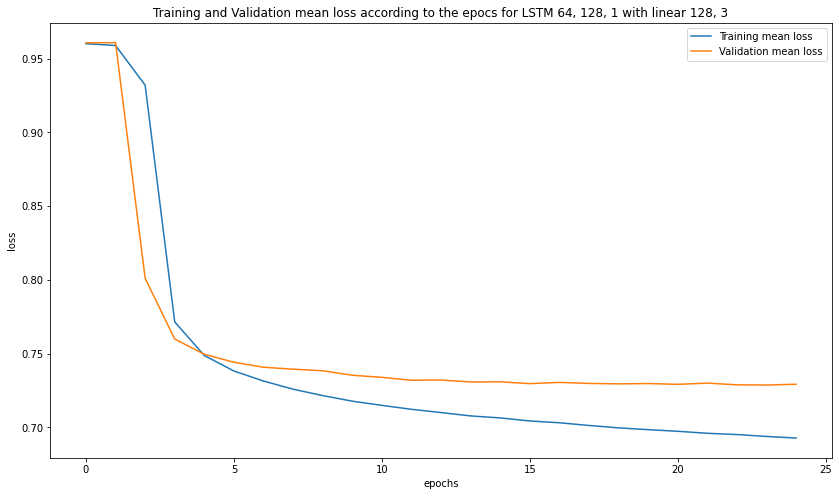

In [150]:
plt.figure(figsize = [14, 8])
plt.plot(range(n_epochs), t_losses, label = "Training mean loss")
plt.plot(range(n_epochs), v_losses, label = "Validation mean loss")
plt.title("Training and Validation mean loss according to the epocs for LSTM 64, 128, 1 with linear 128, 3")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.legend()
plt.show()

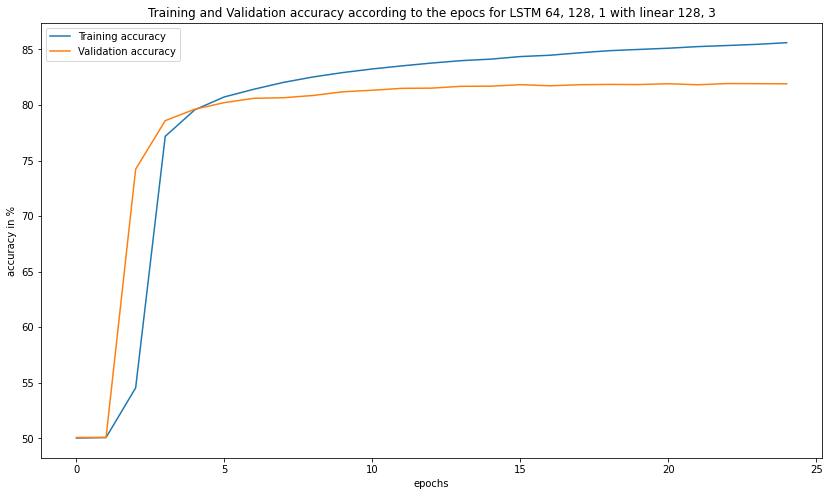

In [149]:
plt.figure(figsize = [14, 8])
plt.plot(range(n_epochs), np.array(t_accs) * 100, label = "Training accuracy")
plt.plot(range(n_epochs), np.array(v_accs) * 100, label = "Validation accuracy")
plt.title("Training and Validation accuracy according to the epocs for LSTM 64, 128, 1 with linear 128, 3")
plt.xlabel("epochs")
plt.ylabel("accuracy in %")
plt.legend()
plt.show()

In [103]:
preds = model.predict(test_data_encode1)
preds = [[i, preds[i]] for i in range(len(preds))]
df = pd.DataFrame(preds, columns = ["id", "target"])
df.to_csv("./predictions_lstm_4.csv", index = False)

  0%|          | 0/1095 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


In [106]:
class GRU(nn.Module) :
    
    def __init__(self, vocabulary_size, embedding_size, hidden_size, n_layers, dims_linear, use_dropout=False, p_dropout=0.1, activation_str = "sigmoid") :
        super(GRU, self).__init__()
        
        self.vocabulary_size = vocabulary_size
        self.embedding_size = embedding_size
        self.hidden_size = hidden_size
        self.n_layers = n_layers
        self.use_dropout = use_dropout

        self.embedding = nn.Embedding(self.vocabulary_size, self.embedding_size, special_idx["pad"])
        if self.use_dropout:
            self.dropout = nn.Dropout(p_dropout)
        self.gru = nn.GRU(self.embedding_size, self.hidden_size, self.n_layers, batch_first=True)
        
        self.dims_linear = dims_linear
        self.n_hidden = len(dims_linear) - 2
        self.activation_str = activation_str
        self.linear_layers = []
        for i in range(self.n_hidden + 1) :
            self.linear_layers.append(nn.Linear(self.dims_linear[i], self.dims_linear[i+1]))
            if i == self.n_hidden :
                self.linear_layers.append(nn.Softmax())
            else :
                if self.activation_str == "sigmoid" :
                    self.linear_layers.append(nn.Sigmoid())
                elif self.activation_str == "relu":
                    self.linear_layers.append(nn.ReLU())
                elif self.activation_str == "tanh":
                    self.linear_layers.append(nn.Tanh())
                else:
                    raise Exception("Invalid activation")
                    
        self.linear = nn.Sequential(*self.linear_layers)
        
        self.criterion = nn.CrossEntropyLoss(ignore_index=special_idx["pad"])
        self.optimizer = optim.Adam(self.parameters())
        
    def forward(self, x):
        #h_0 = Variable(torch.zeros(self.n_layers, x.size(0), self.hidden_size).to(device))
        #c_0 = Variable(torch.zeros(self.n_layers, x.size(0), self.hidden_size).to(device))
        #output, (final_hidden_state, final_cell_state) = self.lstm(x, (h_0, c_0))
        #return self.linear(final_hidden_state[-1])
        x = self.embedding(x)
        if self.use_dropout :
            x = self.dropout(x)
        out, h = self.gru(x)
        return self.linear(h[-1])
    
    def train_loop(self, epoch, train_data, train_labels, bs=512) :
        train_acc = 0.
        train_loss = 0.
        model.train()
        l = len(train_data)
        for i in tqdm(range(0, l, bs)):
            inputs = Variable(train_data[i:i+bs])
            labels = Variable(train_labels[i:i+bs])
            self.optimizer.zero_grad()
            outputs = self.forward(inputs)
            loss = self.criterion(outputs, labels)
            loss.backward()
            train_loss += loss.item()
            train_acc += float(torch.sum(torch.argmax(outputs, dim=1) == labels))
            self.optimizer.step()
        train_loss, train_acc = train_loss / (l//bs), train_acc / l

        print(f"Epoch: {epoch} | Train Acc: {train_acc:.6f} | Train Loss: {train_loss:.6f}")
        return train_acc, train_loss
    
    def valid_loop(self, epoch, val_data, val_labels, bs=512):
        val_acc = 0.
        val_loss = 0.
        model.eval()
        l = len(val_data)
        with torch.no_grad():
            for i in tqdm(range(0, l, bs)):
                inputs = Variable(val_data[i:i+bs])
                labels = Variable(val_labels[i:i+bs])
                outputs = self.forward(inputs)
                loss = self.criterion(outputs, labels)
                val_loss += loss.item()
                val_acc += float(torch.sum(torch.argmax(outputs, dim=1) == labels))
        val_loss, val_acc = val_loss / (l//bs), val_acc / l

        print(f"Epoch: {epoch} | Val Acc: {val_acc:.6f}   | Val Loss: {val_loss:.6f}")
        return val_acc, val_loss
    
    def predict(self, test_data, bs=512) :
        preds = []
        for i in tqdm(range(0, len(test_data), bs)) :
            inputs = Variable(test_data[i:i+bs])
            preds += list(self.forward(inputs).detach().cpu().numpy().argmax(axis=1))
            del inputs
        return preds

In [ ]:
64, 256, 1, (256, 3), True, 0.3 #check
64, 512, 1, (512, 64, 3), True, 0.3  # graph à faire
50, 100, 1, (100, 3), True, 0.2  #check

In [136]:
t_accs, t_losses, v_accs, v_losses = [], [], [], []
n_epochs = 25

model_gru_3 = GRU(len(vocab1), 64, 256, 1, (256, 3), True, 0.3).to(device)

for epoch in range(n_epochs):
    # Training
    t_acc, t_loss = model_gru_3.train_loop(epoch, t_data1, t_labels1)
    t_accs.append(t_acc)
    t_losses.append(t_loss)

    # Validation
    v_acc, v_loss = model_gru_3.valid_loop(epoch, v_data1, v_labels1)
    v_accs.append(v_acc)
    v_losses.append(v_loss)

  0%|          | 0/1611 [00:00<?, ?it/s]

Epoch: 0 | Train Acc: 0.729041 | Train Loss: 0.808743


  0%|          | 0/403 [00:00<?, ?it/s]

Epoch: 0 | Val Acc: 0.775359   | Val Loss: 0.768811


  0%|          | 0/1611 [00:00<?, ?it/s]

Epoch: 1 | Train Acc: 0.789799 | Train Loss: 0.754375


  0%|          | 0/403 [00:00<?, ?it/s]

Epoch: 1 | Val Acc: 0.793259   | Val Loss: 0.752306


  0%|          | 0/1611 [00:00<?, ?it/s]

Epoch: 2 | Train Acc: 0.804784 | Train Loss: 0.740312


  0%|          | 0/403 [00:00<?, ?it/s]

Epoch: 2 | Val Acc: 0.800915   | Val Loss: 0.744851


  0%|          | 0/1611 [00:00<?, ?it/s]

Epoch: 3 | Train Acc: 0.814244 | Train Loss: 0.731717


  0%|          | 0/403 [00:00<?, ?it/s]

Epoch: 3 | Val Acc: 0.806248   | Val Loss: 0.739602


  0%|          | 0/1611 [00:00<?, ?it/s]

Epoch: 4 | Train Acc: 0.820981 | Train Loss: 0.725277


  0%|          | 0/403 [00:00<?, ?it/s]

Epoch: 4 | Val Acc: 0.807490   | Val Loss: 0.739747


  0%|          | 0/1611 [00:00<?, ?it/s]

Epoch: 5 | Train Acc: 0.825946 | Train Loss: 0.720402


  0%|          | 0/403 [00:00<?, ?it/s]

Epoch: 5 | Val Acc: 0.810857   | Val Loss: 0.736172


  0%|          | 0/1611 [00:00<?, ?it/s]

Epoch: 6 | Train Acc: 0.830176 | Train Loss: 0.716565


  0%|          | 0/403 [00:00<?, ?it/s]

Epoch: 6 | Val Acc: 0.813060   | Val Loss: 0.734799


  0%|          | 0/1611 [00:00<?, ?it/s]

Epoch: 7 | Train Acc: 0.833728 | Train Loss: 0.713463


  0%|          | 0/403 [00:00<?, ?it/s]

Epoch: 7 | Val Acc: 0.813710   | Val Loss: 0.733787


  0%|          | 0/1611 [00:00<?, ?it/s]

Epoch: 8 | Train Acc: 0.836806 | Train Loss: 0.710511


  0%|          | 0/403 [00:00<?, ?it/s]

Epoch: 8 | Val Acc: 0.814147   | Val Loss: 0.733191


  0%|          | 0/1611 [00:00<?, ?it/s]

Epoch: 9 | Train Acc: 0.839182 | Train Loss: 0.708262


  0%|          | 0/403 [00:00<?, ?it/s]

Epoch: 9 | Val Acc: 0.814729   | Val Loss: 0.732694


  0%|          | 0/1611 [00:00<?, ?it/s]

Epoch: 10 | Train Acc: 0.841771 | Train Loss: 0.705885


  0%|          | 0/403 [00:00<?, ?it/s]

Epoch: 10 | Val Acc: 0.816820   | Val Loss: 0.730941


  0%|          | 0/1611 [00:00<?, ?it/s]

Epoch: 11 | Train Acc: 0.843585 | Train Loss: 0.703994


  0%|          | 0/403 [00:00<?, ?it/s]

Epoch: 11 | Val Acc: 0.816141   | Val Loss: 0.731731


  0%|          | 0/1611 [00:00<?, ?it/s]

Epoch: 12 | Train Acc: 0.845668 | Train Loss: 0.702300


  0%|          | 0/403 [00:00<?, ?it/s]

Epoch: 12 | Val Acc: 0.816660   | Val Loss: 0.730956


  0%|          | 0/1611 [00:00<?, ?it/s]

Epoch: 13 | Train Acc: 0.847801 | Train Loss: 0.700396


  0%|          | 0/403 [00:00<?, ?it/s]

Epoch: 13 | Val Acc: 0.817689   | Val Loss: 0.730174


  0%|          | 0/1611 [00:00<?, ?it/s]

Epoch: 14 | Train Acc: 0.848550 | Train Loss: 0.699435


  0%|          | 0/403 [00:00<?, ?it/s]

Epoch: 14 | Val Acc: 0.817262   | Val Loss: 0.730720


  0%|          | 0/1611 [00:00<?, ?it/s]

Epoch: 15 | Train Acc: 0.850483 | Train Loss: 0.697757


  0%|          | 0/403 [00:00<?, ?it/s]

Epoch: 15 | Val Acc: 0.818252   | Val Loss: 0.729833


  0%|          | 0/1611 [00:00<?, ?it/s]

Epoch: 16 | Train Acc: 0.851038 | Train Loss: 0.696968


  0%|          | 0/403 [00:00<?, ?it/s]

Epoch: 16 | Val Acc: 0.816636   | Val Loss: 0.730724


  0%|          | 0/1611 [00:00<?, ?it/s]

Epoch: 17 | Train Acc: 0.850311 | Train Loss: 0.698009


  0%|          | 0/403 [00:00<?, ?it/s]

Epoch: 17 | Val Acc: 0.817063   | Val Loss: 0.731185


  0%|          | 0/1611 [00:00<?, ?it/s]

Epoch: 18 | Train Acc: 0.851073 | Train Loss: 0.696919


  0%|          | 0/403 [00:00<?, ?it/s]

Epoch: 18 | Val Acc: 0.818014   | Val Loss: 0.729863


  0%|          | 0/1611 [00:00<?, ?it/s]

Epoch: 19 | Train Acc: 0.853975 | Train Loss: 0.694452


  0%|          | 0/403 [00:00<?, ?it/s]

Epoch: 19 | Val Acc: 0.818004   | Val Loss: 0.730134


  0%|          | 0/1611 [00:00<?, ?it/s]

Epoch: 20 | Train Acc: 0.855062 | Train Loss: 0.693385


  0%|          | 0/403 [00:00<?, ?it/s]

Epoch: 20 | Val Acc: 0.817267   | Val Loss: 0.731181


  0%|          | 0/1611 [00:00<?, ?it/s]

Epoch: 21 | Train Acc: 0.855887 | Train Loss: 0.692656


  0%|          | 0/403 [00:00<?, ?it/s]

Epoch: 21 | Val Acc: 0.818285   | Val Loss: 0.729892


  0%|          | 0/1611 [00:00<?, ?it/s]

Epoch: 22 | Train Acc: 0.856631 | Train Loss: 0.691947


  0%|          | 0/403 [00:00<?, ?it/s]

Epoch: 22 | Val Acc: 0.818140   | Val Loss: 0.730057


  0%|          | 0/1611 [00:00<?, ?it/s]

Epoch: 23 | Train Acc: 0.857356 | Train Loss: 0.691196


  0%|          | 0/403 [00:00<?, ?it/s]

Epoch: 23 | Val Acc: 0.817305   | Val Loss: 0.730652


  0%|          | 0/1611 [00:00<?, ?it/s]

Epoch: 24 | Train Acc: 0.857735 | Train Loss: 0.690622


  0%|          | 0/403 [00:00<?, ?it/s]

Epoch: 24 | Val Acc: 0.818562   | Val Loss: 0.729859


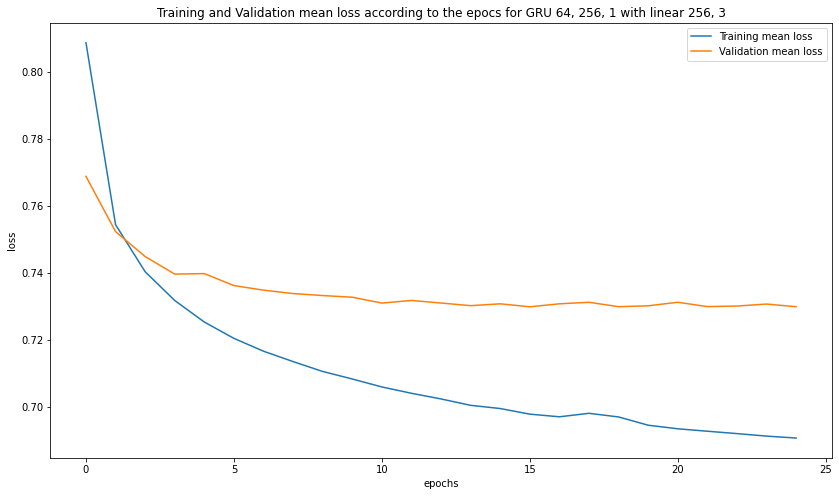

In [138]:
plt.figure(figsize = [14, 8])
plt.plot(range(n_epochs), t_losses, label = "Training mean loss")
plt.plot(range(n_epochs), v_losses, label = "Validation mean loss")
plt.title("Training and Validation mean loss according to the epocs for GRU 64, 256, 1 with linear 256, 3")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.legend()
plt.show()

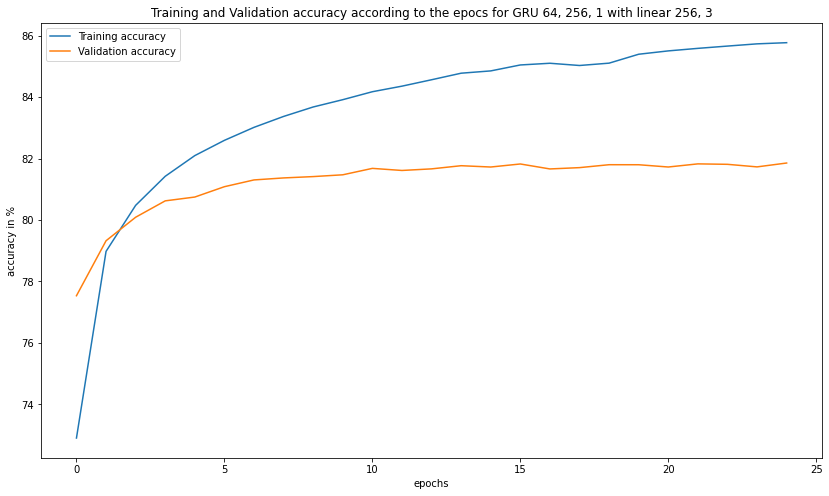

In [139]:
plt.figure(figsize = [14, 8])
plt.plot(range(n_epochs), np.array(t_accs) * 100, label = "Training accuracy")
plt.plot(range(n_epochs), np.array(v_accs) * 100, label = "Validation accuracy")
plt.title("Training and Validation accuracy according to the epocs for GRU 64, 256, 1 with linear 256, 3")
plt.xlabel("epochs")
plt.ylabel("accuracy in %")
plt.legend()
plt.show()

In [ ]:
preds = model.predict(test_data)
preds = [[i, preds[i]] for i in range(len(preds))]
df = pd.DataFrame(preds, columns = ["id", "target"])
df.to_csv("./predictions_gru.csv", index = False)

In [151]:
model_gru_1
model_gru_2
model_gru_3
model_lstm_1
model_lstm_2

LSTM(
  (embedding): Embedding(190322, 64, padding_idx=1)
  (dropout): Dropout(p=0.3, inplace=False)
  (lstm): LSTM(64, 128, batch_first=True)
  (linear): Sequential(
    (0): Linear(in_features=128, out_features=3, bias=True)
    (1): Softmax(dim=None)
  )
  (criterion): CrossEntropyLoss()
)

In [158]:
preds_gru_1 = np.array(model_gru_1.predict(test_data_encode1))
preds_gru_2 = np.array(model_gru_2.predict(test_data_encode1))
preds_gru_3 = np.array(model_gru_3.predict(test_data_encode1))
preds_lstm_1 = np.array(model_lstm_1.predict(test_data_encode1))
preds_lstm_2 = np.array(model_lstm_2.predict(test_data_encode1))

  0%|          | 0/1095 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


  0%|          | 0/1095 [00:00<?, ?it/s]

  0%|          | 0/1095 [00:00<?, ?it/s]

  0%|          | 0/1095 [00:00<?, ?it/s]

  0%|          | 0/1095 [00:00<?, ?it/s]

In [172]:
stack = np.column_stack((preds_gru_1, preds_gru_2, preds_gru_3, preds_lstm_1, preds_lstm_2))
stack

array([[0, 0, 0, 0, 0],
       [2, 2, 2, 2, 2],
       [0, 0, 0, 0, 0],
       ...,
       [0, 0, 0, 0, 0],
       [0, 2, 0, 0, 0],
       [2, 2, 0, 2, 2]])

In [173]:
preds = []
for i in range(stack.shape[0]) :
    preds.append(np.bincount(stack[i,:]).argmax())

In [177]:
preds = [[i, preds[i]] for i in range(len(preds))]
df = pd.DataFrame(preds, columns = ["id", "target"])
df.to_csv("./predictions_ensembliste.csv", index = False)